In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.stats.api as sms

Load Data

In [ ]:
import os

from google.colab import drive
drive.mount('/content/gdrive')
hands = pd.read_csv("/content/gdrive/My Drive/MRA/datania1k.csv")
hands.info()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1000 non-null   int64  
 1   Gender                1000 non-null   object 
 2   Age                   1000 non-null   int64  
 3   Driving_License       1000 non-null   int64  
 4   Region_Code           1000 non-null   float64
 5   Previously_Insured    1000 non-null   int64  
 6   Vehicle_Age           1000 non-null   object 
 7   Vehicle_Damage        1000 non-null   object 
 8   Annual_Premium        1000 non-null   float64
 9   Policy_Sales_Channel  1000 non-null   float64
 10  Vintage               1000 non-null   int64  
 11  Response              1000 non-null   int64  
dtypes: float64(3), int64(6), object(3)
memory us

**Split Data** \
Memisahkan data dengan 80% sebagai training data dan 20% sebagai test data

In [ ]:
from sklearn.model_selection import train_test_split

feature = hands.drop(columns=['id','Gender','Vehicle_Age','Vehicle_Damage','Response'])
target = hands[['Response']]

feature_admit_train, feature_admit_test, target_admit_train, target_admit_test = train_test_split(feature, target, test_size=0.20, random_state=1)

**Multicollinearity Handling** \
Mendeteksi multicollinearity dengan menentukan nilai VIF pada setiap variabel

In [ ]:
# calculate vif score for each column in feature_admit_train
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant

X = add_constant(feature_admit_train)

vif_df = (pd.DataFrame(
            [vif(X.values, i) for i in range(len(X.columns))]
            ,index=X.columns)
            .reset_index())

vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,Age,1.508021
2,Driving_License,1.015138
3,Region_Code,1.008177
4,Previously_Insured,1.077662
5,Annual_Premium,1.034833
6,Policy_Sales_Channel,1.476214
7,Vintage,1.010307


Karena semua variabel memiliki nilai VIF <= 1, maka tidak perlu lakukan correlation analysis.

**Heatmap Correlation** \
Visual hubungan antar variabel

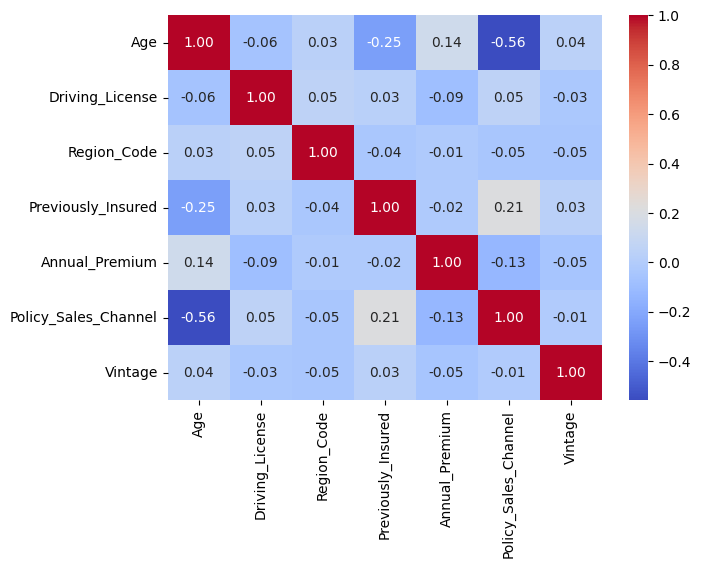

In [ ]:
# heatmap correlation
admit_train = pd.concat([feature_admit_train, target_admit_train], axis=1)
corr = feature_admit_train.select_dtypes(include=np.number).corr()

plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

**Transform to Numpy** \
Mengubah tipe data dari DataFrame (pandas) menjadi array (NumPy).

In [ ]:
# tranform ke numpy array
# train the model
X_admit_train = feature_admit_train.to_numpy()
y_admit_train = target_admit_train.to_numpy().ravel()

Selanjutnya akan dibuat model yang lebih akurat menggunakan dua model regresi yaitu ridge dan lasso

Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge

# define the model
ridge_reg = Ridge(alpha=10,
                  random_state=1)

# train model
ridge_reg.fit(X_admit_train, y_admit_train)

Ridge(alpha=10, random_state=1)

In [ ]:
# retrieve the coefficients
# show as a nice dataframe

data = feature_admit_train
model = ridge_reg

coef_df = pd.DataFrame({
    'feature':['intercept'] + data.columns.tolist(),
    'coefficient':[model.intercept_] + list(model.coef_)
})

coef_df

,feature,coefficient
0,intercept,2.282815e-01
1,Age,4.466500e-04
2,Driving_License,2.730982e-02
3,Region_Code,-4.829222e-04
4,Previously_Insured,-1.775466e-01
5,Annual_Premium,5.763411e-07
6,Policy_Sales_Channel,-7.204487e-04
7,Vintage,-1.908980e-05


Dengan nilai alpha 10 dan misalkan \
Age = x1 \
Driving_License = x2 \
Region_Code = x3 \
Previously_Insured = x4 \
Annual_Premium = x5 \
Policy_Sales_Channel = x6 \
Vintage = x7 \
Maka diperoleh bentuk model ridge regression sebagai berikut \
Y = 0,2282815 + 0,00044x1 + 0,027x2 - 0,00048x3 - 0,177x4 + 0,000000576x5 - 0,00072x6 - 0,000019x7

Kemudian dilakukan Uji Asumsi Klasik pada model yang telah dibentuk

Uji Normalitas Residual

In [ ]:
# --- Residual ---
y_pred = ridge_reg.predict(X_admit_train)
residuals = y_admit_train - y_pred

shapiro_test = stats.shapiro(residuals)
print("Uji Normalitas (Shapiro-Wilk):")
print(f"Statistic = {shapiro_test.statistic:.4f}, p-value = {shapiro_test.pvalue:.4f}")

if shapiro_test.pvalue > 0.05:
    print("Residual berdistribusi normal (p > 0.05)\n")
else:
    print("Residual tidak berdistribusi normal (p ≤ 0.05)\n")

Uji Normalitas (Shapiro-Wilk):
Statistic = 0.6940, p-value = 0.0000
Residual tidak berdistribusi normal (p ≤ 0.05)



Uji Homogenitas

In [ ]:
print("Uji Homogenitas (Breusch-Pagan)")

X_with_const = sm.add_constant(X_admit_train)

# Iterate over the column names from the original DataFrame
for i, col_name in enumerate(feature_admit_train.columns):

    exog_for_test = X_with_const[:, [0, i+1]]

    bp_test = sms.het_breuschpagan(residuals, exog_for_test)
    p_value = bp_test[1]
    print(f"{col_name:25s} → p-value = {p_value:.4f}",
          "Homogen" if p_value > 0.05 else "Tidak homogen")

print()

Uji Homogenitas (Breusch-Pagan)
Age                       → p-value = 0.0000 Tidak homogen
Driving_License           → p-value = 0.9099 Homogen
Region_Code               → p-value = 0.7791 Homogen
Previously_Insured        → p-value = 0.0000 Tidak homogen
Annual_Premium            → p-value = 0.2236 Homogen
Policy_Sales_Channel      → p-value = 0.0000 Tidak homogen
Vintage                   → p-value = 0.4922 Homogen



Uji Autokorelasi

In [ ]:
from statsmodels.stats.stattools import durbin_watson
dw = durbin_watson(residuals)
print("Uji Autokorelasi (Durbin-Watson)")
print(f"Durbin-Watson statistic: {dw:.4f}")

# Interpretasi umum
if dw < 1.5:
    print("Ada indikasi autokorelasi positif\n")
elif dw > 2.5:
    print("Ada indikasi autokorelasi negatif\n")
else:
    print("Tidak ada indikasi autokorelasi (nilai mendekati 2)\n")

Uji Autokorelasi (Durbin-Watson)
Durbin-Watson statistic: 1.9717
Tidak ada indikasi autokorelasi (nilai mendekati 2)



Lasso Regression

In [ ]:
from sklearn.linear_model import Lasso

# define the model
lasso_reg = Lasso(alpha=10,
                  random_state=1)

# train
lasso_reg.fit(X_admit_train, y_admit_train)

Lasso(alpha=10, random_state=1)

In [ ]:
# retrieve the coefficients
# show as a nice dataframe

data = feature_admit_train
model = lasso_reg

coef_df = pd.DataFrame({
    'feature':['intercept'] + data.columns.tolist(),
    'coefficient':[model.intercept_] + list(model.coef_)
})

coef_df

,feature,coefficient
0,intercept,0.094058
1,Age,0.000000
2,Driving_License,0.000000
3,Region_Code,-0.000000
4,Previously_Insured,-0.000000
5,Annual_Premium,0.000001
6,Policy_Sales_Channel,-0.000000
7,Vintage,-0.000000


Dengan nilai alpha 10 dan misalkan \
Age = x1 \
Driving_License = x2 \
Region_Code = x3 \
Previously_Insured = x4 \
Annual_Premium = x5 \
Policy_Sales_Channel = x6 \
Vintage = x7 \
Maka diperoleh bentuk model lasso regression sebagai berikut \
Y = 0.094058 + 0.000001x5

Kemudian dilakukan Uji Asumsi Klasik pada model yang telah dibentuk

Uji Normalitas Residual

In [ ]:
# --- Residual ---
y_pred = ridge_reg.predict(X_admit_train)
residuals = y_admit_train - y_pred

shapiro_test = stats.shapiro(residuals)
print("Uji Normalitas (Shapiro-Wilk):")
print(f"Statistic = {shapiro_test.statistic:.4f}, p-value = {shapiro_test.pvalue:.4f}")

if shapiro_test.pvalue > 0.05:
    print("Residual berdistribusi normal (p > 0.05)\n")
else:
    print("Residual tidak berdistribusi normal (p ≤ 0.05)\n")

Uji Normalitas (Shapiro-Wilk):
Statistic = 0.6940, p-value = 0.0000
Residual tidak berdistribusi normal (p ≤ 0.05)



Uji Homogenitas

In [ ]:
print("Uji Homogenitas (Breusch-Pagan)")

X_with_const = sm.add_constant(X_admit_train)

# Iterate over the column names from the original DataFrame
for i, col_name in enumerate(feature_admit_train.columns):

    exog_for_test = X_with_const[:, [0, i+1]]

    bp_test = sms.het_breuschpagan(residuals, exog_for_test)
    p_value = bp_test[1]
    print(f"{col_name:25s} → p-value = {p_value:.4f}",
          "Homogen" if p_value > 0.05 else "Tidak homogen")

print()

Uji Homogenitas (Breusch-Pagan)
Age                       → p-value = 0.0000 Tidak homogen
Driving_License           → p-value = 0.9099 Homogen
Region_Code               → p-value = 0.7791 Homogen
Previously_Insured        → p-value = 0.0000 Tidak homogen
Annual_Premium            → p-value = 0.2236 Homogen
Policy_Sales_Channel      → p-value = 0.0000 Tidak homogen
Vintage                   → p-value = 0.4922 Homogen



Uji Autokorelasi

In [ ]:
from statsmodels.stats.stattools import durbin_watson
dw = durbin_watson(residuals)
print("Uji Autokorelasi (Durbin-Watson)")
print(f"Durbin-Watson statistic: {dw:.4f}")

# Interpretasi umum
if dw < 1.5:
    print("Ada indikasi autokorelasi positif\n")
elif dw > 2.5:
    print("Ada indikasi autokorelasi negatif\n")
else:
    print("Tidak ada indikasi autokorelasi (nilai mendekati 2)\n")

Uji Autokorelasi (Durbin-Watson)
Durbin-Watson statistic: 1.9717
Tidak ada indikasi autokorelasi (nilai mendekati 2)



**Split data: train-validation-test** \
Memisahkan data sebagai training data, validation data, dan test data

In [ ]:
# split train test
from sklearn.model_selection import train_test_split

feature = hands.drop(columns=['id','Gender','Vehicle_Age','Vehicle_Damage','Response'])
target = hands[['Response']]

# First splitting: pretrain and test
feature_admit_pretrain, feature_admit_test, target_admit_pretrain, target_admit_test = train_test_split(feature, target, test_size=0.20, random_state=1)

# Second splitting: train and validation
feature_admit_train, feature_admit_validation, target_admit_train, target_admit_validation = train_test_split(feature_admit_pretrain, target_admit_pretrain, test_size=0.20, random_state=1)

**Train Multiple Models with different alpha (lambda)** \
Melakukan uji model dengan nilai aplha (lambda) yang berbeda

In [ ]:
# convert to numpy array
X_admit_train = feature_admit_train.to_numpy()
y_admit_train = target_admit_train.to_numpy().ravel()

Ridge

In [ ]:
from sklearn.linear_model import Ridge

# define the model
# multiple models with different alphas (lambda)
ridge_reg_pointzeroone = Ridge(alpha=0.01, random_state=1)
ridge_reg_pointone = Ridge(alpha=0.1, random_state=1)
ridge_reg_one = Ridge(alpha=1, random_state=1)
ridge_reg_ten = Ridge(alpha=10, random_state=1)
ridge_reg_hundred = Ridge(alpha=100, random_state=1)

# fit the model (training)
ridge_reg_pointzeroone.fit(X_admit_train, y_admit_train)
ridge_reg_pointone.fit(X_admit_train, y_admit_train)
ridge_reg_one.fit(X_admit_train, y_admit_train)
ridge_reg_ten.fit(X_admit_train, y_admit_train)
ridge_reg_hundred.fit(X_admit_train, y_admit_train)

Ridge(alpha=100, random_state=1)

**Find the best model (alpha) Based on validation set** \
Menentukan model ridge terbaik berdasarkan nilai alpha

In [ ]:
from sklearn.metrics import mean_squared_error

X_admit_validation = feature_admit_validation.to_numpy()
y_admit_validation = target_admit_validation.to_numpy().ravel()

alphas = [0.01, 0.1, 1., 10, 100]
models = [ridge_reg_pointzeroone,
          ridge_reg_pointone,
          ridge_reg_one,
          ridge_reg_ten,
          ridge_reg_hundred]

for model, alpha in zip(models, alphas):
    y_predict_validation = model.predict(X_admit_validation)
    rmse = np.sqrt(mean_squared_error(y_admit_validation,y_predict_validation))
    print(f'RMSE of Ridge regression model with alpha = {alpha} is {rmse}')

RMSE of Ridge regression model with alpha = 0.01 is 0.3141951342614132
RMSE of Ridge regression model with alpha = 0.1 is 0.3141958733363844
RMSE of Ridge regression model with alpha = 1.0 is 0.31419662156073186
RMSE of Ridge regression model with alpha = 10 is 0.3141781100026808
RMSE of Ridge regression model with alpha = 100 is 0.3157867812974024


Maka model terbaik adalah model dengan nilai alpha 10

**Coefficients** \
Kemudian menentukan nilai koefisien model ridge

In [ ]:
ridge_best = ridge_reg_ten

coef_df = pd.DataFrame({
    'feature':['intercept'] + feature_admit_train.columns.tolist(),
    'coefficient':[ridge_best.intercept_] + list(ridge_best.coef_)
})

coef_df

,feature,coefficient
0,intercept,2.629113e-01
1,Age,1.204352e-04
2,Driving_License,2.675853e-02
3,Region_Code,-5.327196e-04
4,Previously_Insured,-1.772556e-01
5,Annual_Premium,9.023438e-07
6,Policy_Sales_Channel,-7.344413e-04
7,Vintage,-1.950353e-04


Misalkan \
Age = x1 \
Driving_License = x2 \
Region_Code = x3 \
Previously_Insured = x4 \
Annual_Premium = x5 \
Policy_Sales_Channel = x6 \
Vintage = x7 \
Maka modelnya adalah \
Y = 0,2629113 + 0,00012x1 + 0,0267x2 - 0,00053x3 - 0,177x4 + 0,0000009x5 - 0,00073x6 - 0,000195x7

Lasso

In [ ]:
from sklearn.linear_model import Lasso

# define the model
# multiple models with different alphas (lambda)
lasso_reg_pointzeroone = Lasso(alpha=0.01, random_state=1)
lasso_reg_pointone = Lasso(alpha=0.1, random_state=1)
lasso_reg_one = Lasso(alpha=1, random_state=1)
lasso_reg_ten = Lasso(alpha=10, random_state=1)
lasso_reg_hundred = Lasso(alpha=100, random_state=1)

# fit the model (training)
lasso_reg_pointzeroone.fit(X_admit_train, y_admit_train)
lasso_reg_pointone.fit(X_admit_train, y_admit_train)
lasso_reg_one.fit(X_admit_train, y_admit_train)
lasso_reg_ten.fit(X_admit_train, y_admit_train)
lasso_reg_hundred.fit(X_admit_train, y_admit_train)

Lasso(alpha=100, random_state=1)

**Find the best model (alpha) Based on validation set** \
Menentukan model lasso terbaik berdasarkan nilai alpha

In [ ]:
from sklearn.metrics import mean_squared_error

X_admit_validation = feature_admit_validation.to_numpy()
y_admit_validation = target_admit_validation.to_numpy().ravel()

alphas = [0.01, 0.1, 1., 10, 100]
models = [lasso_reg_pointzeroone,
          lasso_reg_pointone,
          lasso_reg_one,
          lasso_reg_ten,
          lasso_reg_hundred]

for model, alpha in zip(models, alphas):
    y_predict_validation = model.predict(X_admit_validation)
    rmse = np.sqrt(mean_squared_error(y_admit_validation,y_predict_validation))
    print(f'RMSE of Lasso regression model with alpha = {alpha} is {rmse}')

RMSE of Lasso regression model with alpha = 0.01 is 0.3146014513431777
RMSE of Lasso regression model with alpha = 0.1 is 0.32566703666114893
RMSE of Lasso regression model with alpha = 1.0 is 0.3257888196913677
RMSE of Lasso regression model with alpha = 10 is 0.33232991293435227
RMSE of Lasso regression model with alpha = 100 is 0.3317780556061909


Maka model terbaik adalah model dengan nilai alpha 0,01

**Coefficient**
Kemudian menentukan nilai koefisien model lasso

In [ ]:
lasso_best = lasso_reg_pointzeroone

coef_df = pd.DataFrame({
    'feature':['intercept'] + feature_admit_train.columns.tolist(),
    'coefficient':[lasso_best.intercept_] + list(lasso_best.coef_)
})

coef_df

,feature,coefficient
0,intercept,2.710035e-01
1,Age,2.790379e-04
2,Driving_License,0.000000e+00
3,Region_Code,-4.090883e-04
4,Previously_Insured,-1.454032e-01
5,Annual_Premium,8.835103e-07
6,Policy_Sales_Channel,-7.574013e-04
7,Vintage,-2.016929e-04


Misalkan \
Age = x1 \
Driving_License = x2 \
Region_Code = x3 \
Previously_Insured = x4 \
Annual_Premium = x5 \
Policy_Sales_Channel = x6 \
Vintage = x7 \
Maka modelnya adalah \
Y = 0,2710035 + 0,000279x1 - 0,000409x3 - 0,145x4 + 0,0000008x5 - 0,00075x6 - 0,000201x7

Training Error

In [ ]:
# prepare prediction result on train data
y_predict_train = ridge_best.predict(X_admit_train)

In [ ]:
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for training data is {}'.format(root_mean_squared_error(y_admit_train, y_predict_train)))
print('MAE for training data is {}'.format(mean_absolute_error(y_admit_train, y_predict_train)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_admit_train, y_predict_train)))

RMSE for training data is 0.31087253613901666
MAE for training data is 0.20554772389846923
MAPE for training data is 490460109962870.2


**Testing Error** \
Kemudian menentukan nilai error

In [ ]:
# prepare prediction result on test data
X_admit_test = feature_admit_test.to_numpy()
y_predict_test = ridge_best.predict(X_admit_test)

# ground truth target
y_admit_test = target_admit_test.to_numpy().ravel()

In [ ]:
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for testing data is {}'.format(root_mean_squared_error(y_admit_test, y_predict_test)))
print('MAE for testing data is {}'.format(mean_absolute_error(y_admit_test, y_predict_test)))
print('MAPE for testing data is {}'.format(mean_absolute_percentage_error(y_admit_test, y_predict_test)))

RMSE for testing data is 0.29935110948025023
MAE for testing data is 0.18532627566925278
MAPE for testing data is 425609935418771.8
